<a href="https://colab.research.google.com/github/ten2net/ppo/blob/main/Day19_%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92%E5%9C%A8%E4%BA%A4%E6%98%93%E4%B8%AD%E7%9A%84%E6%87%89%E7%94%A8_%E7%B5%90%E5%90%88_Stable_Baselines_%E9%80%B2_Backtrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在今日教學中，我們將學習如何結合 Stable Baselines 3 和之前大量篇幅介紹的 Backtrader，使用強化學習方法開發一個股票交易策略，終於有一個大融合的感覺了!我們會附完整程式在最後面，你也可以在 [Colab](https://colab.research.google.com/drive/1QFFwra7tc3-nMQxiPPErcE4oU7dQWKxC?usp=sharing) 上直接運行。
![https://ithelp.ithome.com.tw/upload/images/20241004/20120549UslBIoDP5a.jpg](https://ithelp.ithome.com.tw/upload/images/20241004/20120549UslBIoDP5a.jpg)

### **一、引言**

#### **1. 為什麼選擇 Stable Baselines 3 和 Backtrader**

- **Stable Baselines 3**：一個基於 PyTorch 的強化學習庫，提供了多種先進的強化學習算法，易於使用和擴展。
- **Backtrader**：一個功能強大的 Python 回測框架，支持多種資產類別，具有靈活的策略定義和數據處理能力。
- **結合優勢**：通過結合 Stable Baselines 3 和 Backtrader，我們可以構建一個強化學習代理，並在 Backtrader 中進行回測和評估，充分利用兩者的優勢。

---

### **二、環境設置**

#### **1. 安裝必要的庫**

在 Google Colab 中，我們需要安裝以下庫：


In [ ]:
!pip install stable-baselines3
!pip install gymnasium
!pip install gymnasium[classic_control]
!pip install backtrader
!pip install yfinance
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00


#### **2. 導入庫**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
import gymnasium as gym
from gymnasium import spaces

### **三、數據準備**

#### **1. 獲取股票數據**

我們將使用 `yfinance` 下載蘋果公司（AAPL）的歷史數據。

In [ ]:
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])  # 確保 Date 列為 datetime 類型
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Date', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%***********************]  1 of 1 completed


#### **2. 數據預處理**


In [ ]:
data['Open'] = data['Open'].astype('float32')
data['High'] = data['High'].astype('float32')
data['Low'] = data['Low'].astype('float32')
data['Close'] = data['Close'].astype('float32')
data['Volume'] = data['Volume'].astype('float32')

<ipython-input-4-2b2fe5140f14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Open'] = data['Open'].astype('float32')
<ipython-input-4-2b2fe5140f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['High'] = data['High'].astype('float32')
<ipython-input-4-2b2fe5140f14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

### **四、定義交易環境**

在這一部分，我們將創建一個自訂的交易環境 `TradingEnv`，它繼承自 `gym.Env`，以便與強化學習模型進行交互。這個環境將模擬股票交易的過程，並允許代理在環境中學習交易策略。

#### **1. 環境的結構**

- **觀測空間（Observation Space）**：包含股票的市場數據，例如開盤價、最高價、最低價、收盤價和成交量。
- **行動空間（Action Space）**：代理可以採取的行動，包括買入、賣出和持有。
- **環境狀態**：追蹤代理的持倉、現金餘額和資產淨值。
- **獎勵函數**：根據代理的資產淨值變化計算獎勵，鼓勵代理增加資產淨值。

#### **2. 環境的實作**

In [ ]:
class TradingEnv(gym.Env):
    """自訂的交易環境，用於強化學習模型訓練"""

    def __init__(self, data, cash=10000, commission=0.001):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index()
        self.cash = cash  # 初始現金
        self.initial_cash = cash  # 紀錄初始現金
        self.commission = commission  # 交易手續費
        self.current_step = 0  # 當前時間步

        # 定義觀測空間和行動空間
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # 0: 持有, 1: 買入, 2: 賣出

        # 初始化帳戶資訊
        self.position = 0  # 持有的股票數量
        self.net_worth = self.cash  # 資產淨值
        self.prev_net_worth = self.cash  # 前一步的資產淨值

        # 紀錄交易訊號
        self.trades = []

    def _get_obs(self):
        """獲取當前的觀測值"""
        obs = np.array([
            self.data.loc[self.current_step, 'Open'],
            self.data.loc[self.current_step, 'High'],
            self.data.loc[self.current_step, 'Low'],
            self.data.loc[self.current_step, 'Close'],
            self.data.loc[self.current_step, 'Volume'],
        ], dtype=np.float32)
        return obs

    def reset(self, *, seed=None, options=None):
        """重置環境到初始狀態"""
        super().reset(seed=seed)
        self.current_step = 0
        self.position = 0
        self.cash = self.initial_cash
        self.net_worth = self.cash
        self.prev_net_worth = self.cash
        self.trades = []  # 重置交易紀錄
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        """執行一個行動，並返回新的狀態和獎勵"""
        current_price = self.data.loc[self.current_step, 'Close']

        # 記錄交易訊號
        date = self.data.loc[self.current_step, 'Date']
        self.trades.append({'Date': date, 'Action': action})

        # 計算交易手續費
        commission = 0

        if action == 1:  # 買入
            # 計算可買入的最大股數
            max_shares = int(self.cash / (current_price * (1 + self.commission)))
            if max_shares > 0:
                # 更新帳戶餘額和持倉
                cost = max_shares * current_price * (1 + self.commission)
                self.cash -= cost
                self.position += max_shares
                commission = cost * self.commission
        elif action == 2:  # 賣出
            if self.position > 0:
                # 更新帳戶餘額和持倉
                revenue = self.position * current_price * (1 - self.commission)
                self.cash += revenue
                commission = self.position * current_price * self.commission
                self.position = 0
        # action == 0 表示持有，不執行任何操作

        self.current_step += 1

        # 更新資產淨值
        self.net_worth = self.cash + self.position * current_price

        # 計算獎勵
        reward = self.net_worth - self.prev_net_worth - commission
        self.prev_net_worth = self.net_worth

        # 判斷是否終止
        if self.current_step >= len(self.data) - 1:
            terminated = True
        else:
            terminated = False
        truncated = False

        obs = self._get_obs()
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        """渲染環境（此處未實作）"""
        pass

#### **3. 實作內容說明**

- **`__init__` 方法**：
  - 初始化環境，設定初始現金、手續費和初始狀態。
  - 定義觀測空間和行動空間。
  - 初始化帳戶資訊和交易紀錄。

- **`_get_obs` 方法**：
  - 返回當前時間步的市場數據作為觀測值。

- **`reset` 方法**：
  - 重置環境到初始狀態，清空持倉和交易紀錄。

- **`step` 方法**：
  - 根據代理選擇的行動（買入、賣出、持有）更新帳戶狀態。
  - 計算交易手續費和資產淨值的變化。
  - 計算獎勵，鼓勵代理增加資產淨值。
  - 移動到下一個時間步，並檢查是否終止。

- **`render` 方法**：
  - 可用於渲染環境，此處未實作。

### **五、訓練強化學習模型**

#### **1. 創建環境實例**

In [ ]:
env = TradingEnv(data)


#### **2. 檢查環境**

使用 Stable Baselines 3 提供的工具檢查環境是否符合要求：


In [ ]:
env_checker.check_env(env)


#### **3. 包裝環境**

將環境包裝為向量化環境，以便與 Stable Baselines 3 的算法兼容：

In [ ]:
env = DummyVecEnv([lambda: env])



#### **4. 訓練模型**

使用常見 RL 演算法，今天我們使用 PPO 算法為例進行訓練：

In [ ]:
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 496  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 449         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013087779 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 5.95e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00629    |
|    value_loss           | 9.25e+04    |
-----------------------------------------
----------------

### **六、測試模型並收集交易訊號**


In [ ]:
env.envs[0].reset()
for i in range(len(data) - 1):
    obs = env.envs[0]._get_obs()
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env.envs[0].step(action)
    if dones:
        break

- **說明**：
  - 我們直接訪問未包裝的環境 `env.envs[0]`，以便收集交易訊號。
  - 在每個時間步，模型根據當前觀測值選擇行動，並更新環境狀態。

---

### **七、在 Backtrader 上顯示買賣點**

#### **1. 獲取交易紀錄並合併數據**

In [ ]:
# 從環境中獲取交易紀錄
trades = pd.DataFrame(env.envs[0].trades)

# 將交易紀錄與原始數據合併
data.reset_index(inplace=True)
merged_data = pd.merge(data, trades, on='Date', how='left')
merged_data['Action'].fillna(0, inplace=True)

# 確保 Date 列為 datetime 類型
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

<ipython-input-11-d41afca6bfd7>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Action'].fillna(0, inplace=True)


#### **2. 定義 Backtrader 策略**


In [ ]:
class RLStrategy(bt.Strategy):
    """自訂的策略，用於在圖表上顯示買賣點"""

    def __init__(self):
        self.dataclose = self.datas[0].close

    def next(self):
        # 根據交易紀錄執行買賣
        idx = len(self) - 1  # 當前索引
        action = merged_data.loc[idx, 'Action']
        if action == 1 and self.position.size == 0:
            # 買入
            self.buy(size=100)
        elif action == 2 and self.position.size > 0:
            # 賣出
            self.sell(size=self.position.size)

#### **3. 設置 Backtrader 並進行回測**


In [ ]:
cerebro = bt.Cerebro()
# 在添加數據時，指定 datetime 列
data_bt = bt.feeds.PandasData(
    dataname=merged_data,
    datetime='Date',
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    openinterest=-1,
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data_bt)
cerebro.addstrategy(RLStrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.001)

print('初始資金: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('最終資金: %.2f' % cerebro.broker.getvalue())

初始資金: 10000.00
最終資金: 15904.19


#### **4. 繪製圖表**


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


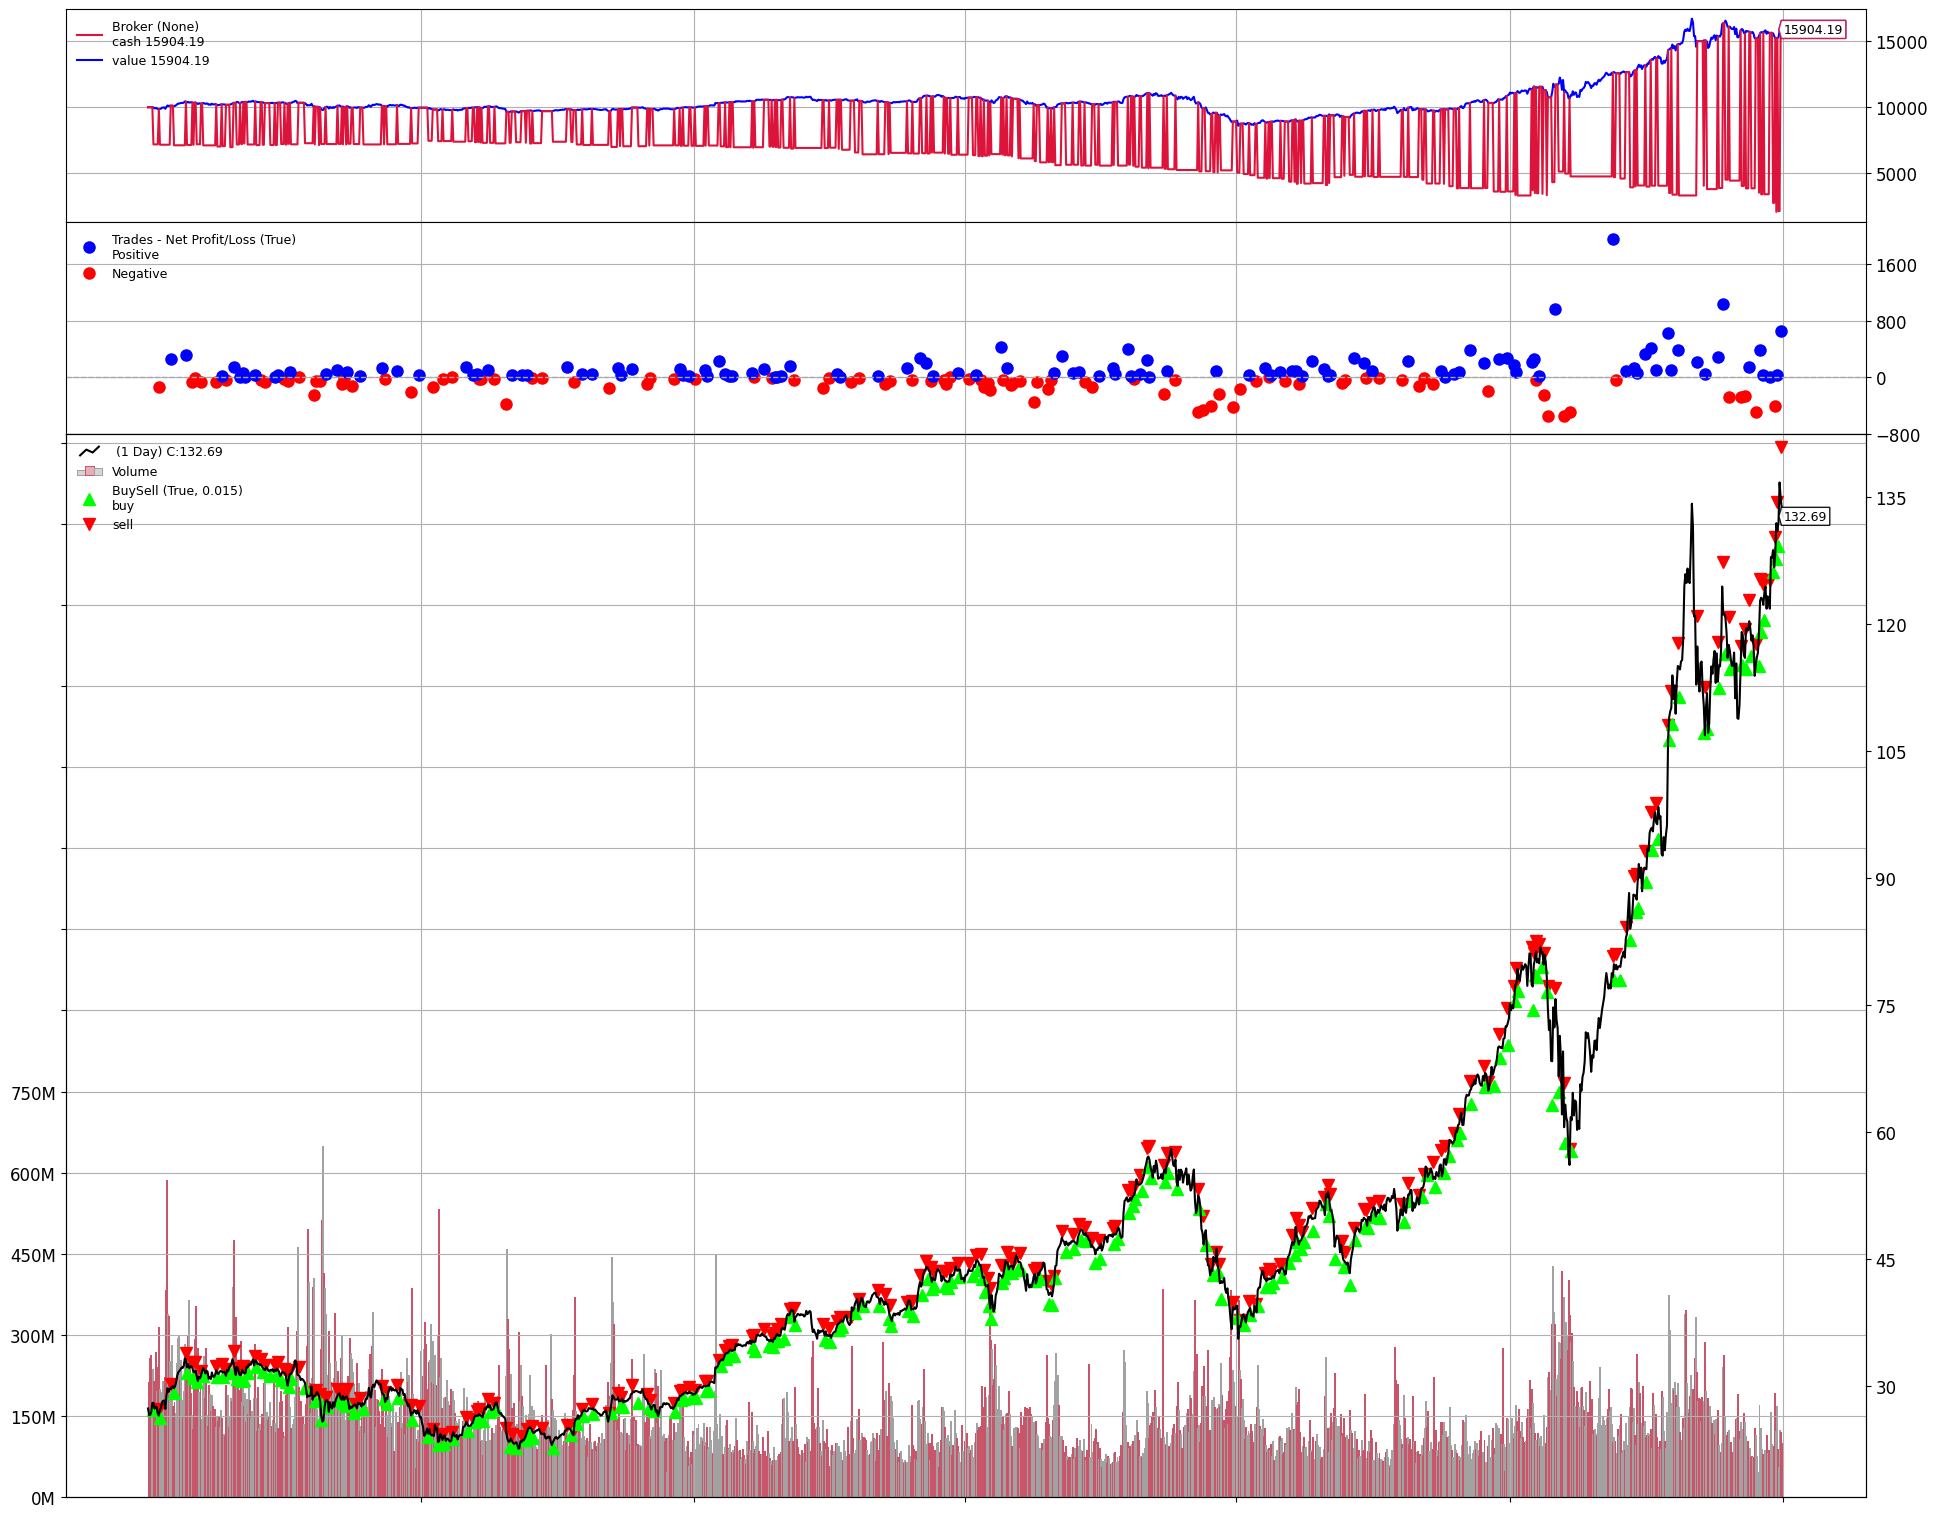

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams.update({'font.size': 12})
img = cerebro.plot(iplot = False)
img[0][0].savefig('backtrader_ppo.png')

### **八、結果分析**

通過 Backtrader 的圖表，我們可以看到模型在測試期間的買賣點，以及資產淨值的變化。這有助於我們直觀地了解模型的交易決策和績效。

- **買賣點**：在圖表上，買入點和賣出點會以特定的標記顯示，方便我們分析代理的交易行為。
- **資產淨值曲線**：觀察資產淨值的走勢，評估策略的收益和風險。

---

### **九、完整程式碼**

以下是完整的程式碼，您可以直接在 Google Colab 上執行。


In [ ]:
# 安裝必要的庫
!pip install stable-baselines3
!pip install gymnasium
!pip install gymnasium[classic_control]
!pip install backtrader
!pip install yfinance
!pip install matplotlib

# 導入庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
import gymnasium as gym
from gymnasium import spaces

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])  # 確保 Date 列為 datetime 類型
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Date', inplace=True)

# 數據預處理
data['Open'] = data['Open'].astype('float32')
data['High'] = data['High'].astype('float32')
data['Low'] = data['Low'].astype('float32')
data['Close'] = data['Close'].astype('float32')
data['Volume'] = data['Volume'].astype('float32')

# 定義交易環境
class TradingEnv(gym.Env):
    """自訂的交易環境，用於強化學習模型訓練"""

    def __init__(self, data, cash=10000, commission=0.001):
        super(TradingEnv, self).__init__()
        self.data = data.reset_index()
        self.cash = cash  # 初始現金
        self.initial_cash = cash  # 紀錄初始現金
        self.commission = commission  # 交易手續費
        self.current_step = 0  # 當前時間步

        # 定義觀測空間和行動空間
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # 0: 持有, 1: 買入, 2: 賣出

        # 初始化帳戶資訊
        self.position = 0  # 持有的股票數量
        self.net_worth = self.cash  # 資產淨值
        self.prev_net_worth = self.cash  # 前一步的資產淨值

        # 紀錄交易訊號
        self.trades = []

    def _get_obs(self):
        """獲取當前的觀測值"""
        obs = np.array([
            self.data.loc[self.current_step, 'Open'],
            self.data.loc[self.current_step, 'High'],
            self.data.loc[self.current_step, 'Low'],
            self.data.loc[self.current_step, 'Close'],
            self.data.loc[self.current_step, 'Volume'],
        ], dtype=np.float32)
        return obs

    def reset(self, *, seed=None, options=None):
        """重置環境到初始狀態"""
        super().reset(seed=seed)
        self.current_step = 0
        self.position = 0
        self.cash = self.initial_cash
        self.net_worth = self.cash
        self.prev_net_worth = self.cash
        self.trades = []  # 重置交易紀錄
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        """執行一個行動，並返回新的狀態和獎勵"""
        current_price = self.data.loc[self.current_step, 'Close']

        # 記錄交易訊號
        date = self.data.loc[self.current_step, 'Date']
        self.trades.append({'Date': date, 'Action': action})

        # 計算交易手續費
        commission = 0

        if action == 1:  # 買入
            # 計算可買入的最大股數
            max_shares = int(self.cash / (current_price * (1 + self.commission)))
            if max_shares > 0:
                # 更新帳戶餘額和持倉
                cost = max_shares * current_price * (1 + self.commission)
                self.cash -= cost
                self.position += max_shares
                commission = cost * self.commission
        elif action == 2:  # 賣出
            if self.position > 0:
                # 更新帳戶餘額和持倉
                revenue = self.position * current_price * (1 - self.commission)
                self.cash += revenue
                commission = self.position * current_price * self.commission
                self.position = 0
        # action == 0 表示持有，不執行任何操作

        self.current_step += 1

        # 更新資產淨值
        self.net_worth = self.cash + self.position * current_price

        # 計算獎勵
        reward = self.net_worth - self.prev_net_worth - commission
        self.prev_net_worth = self.net_worth

        # 判斷是否終止
        if self.current_step >= len(self.data) - 1:
            terminated = True
        else:
            terminated = False
        truncated = False

        obs = self._get_obs()
        info = {}

        return obs, reward, terminated, truncated, info

    def render(self):
        """渲染環境（此處未實作）"""
        pass

# 創建環境實例
env = TradingEnv(data)

# 檢查環境
env_checker.check_env(env)

# 包裝環境
env = DummyVecEnv([lambda: env])

# 訓練模型
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

# 測試模型並收集交易訊號
env.envs[0].reset()
for i in range(len(data) - 1):
    obs = env.envs[0]._get_obs()
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env.envs[0].step(action)
    if dones:
        break

# 從環境中獲取交易紀錄
trades = pd.DataFrame(env.envs[0].trades)

# 將交易紀錄與原始數據合併
data.reset_index(inplace=True)
merged_data = pd.merge(data, trades, on='Date', how='left')
merged_data['Action'].fillna(0, inplace=True)

# 確保 Date 列為 datetime 類型
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# 在 Backtrader 中顯示買賣點
class RLStrategy(bt.Strategy):
    """自訂的策略，用於在圖表上顯示買賣點"""

    def __init__(self):
        self.dataclose = self.datas[0].close

    def next(self):
        # 根據交易紀錄執行買賣
        idx = len(self) - 1  # 當前索引
        action = merged_data.loc[idx, 'Action']
        if action == 1 and self.position.size == 0:
            # 買入
            self.buy(size=100)
        elif action == 2 and self.position.size > 0:
            # 賣出
            self.sell(size=self.position.size)

# 設置 Backtrader
cerebro = bt.Cerebro()
# 在添加數據時，指定 datetime 列
data_bt = bt.feeds.PandasData(
    dataname=merged_data,
    datetime='Date',
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    openinterest=-1,
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data_bt)
cerebro.addstrategy(RLStrategy)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(commission=0.001)

print('初始資金: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('最終資金: %.2f' % cerebro.broker.getvalue())

# 繪製圖表
%matplotlib inline
cerebro.plot(iplot=True, volume=False)

### **十、總結**

在本教學中，我們：

- **結合了 Stable Baselines 3 和 Backtrader**，構建了一個強化學習交易策略。
- **詳細解釋了每個步驟**，包括環境設置、數據準備、環境定義、模型訓練和結果可視化。
- **在環境定義部分**，詳細描述了環境的結構和實作內容，幫助您理解每一段程式碼的作用。

---

### **作業**

1. **添加技術指標**：在環境的觀測值中加入技術指標，例如移動平均線、RSI 等，提升模型的決策能力。
2. **調整超參數**：修改模型的超參數，如學習率、訓練步數等，觀察對模型性能的影響。
3. **嘗試不同的算法**：替換為其他強化學習算法，如 DQN、A2C 等，進行比較。
4. **多資產交易**：將環境擴展為多個股票，測試模型在組合投資中的表現。

---

### **提示**

- **數據質量**：確保數據的完整性，處理缺失值和異常值。
- **環境設計**：仔細設計觀測值和獎勵函數，確保模型能夠學習到有效的策略。
- **模型穩定性**：多次訓練模型，檢驗結果的一致性和穩定性。

---

### **注意事項**

- **風險提示**：金融市場具有高度的不確定性，模型的結果僅供參考，不應作為實際投資決策的唯一依據。
- **合規要求**：遵守相關法律法規和市場規則，合法合規地進行交易。
- **倫理考慮**：確保模型的設計和應用符合道德標準，不得進行市場操縱等不當行為。

---

*希望通過本教學，能夠深入理解如何使用強化學習方法進行量化交易策略的開發，並掌握 Stable Baselines 3 和 Backtrader 的實際應用技巧。*